Import the necessary libraries

In [ ]:
import os
import glob
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from google.colab import drive 

Connect with drive to load the dataset

In [ ]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Checking number of classes

In [ ]:

root_path = '/content/drive/MyDrive/train'
class_names = sorted(os.listdir(root_path))
n_classes = len(class_names)
print(f"Total Number of Classes : {n_classes} \nClass Names : {class_names}")

Total Number of Classes : 15 
Class Names : ['Bean', 'Bitter_Gourd', 'Bottle_Gourd', 'Brinjal', 'Broccoli', 'Cabbage', 'Capsicum', 'Carrot', 'Cauliflower', 'Cucumber', 'Papaya', 'Potato', 'Pumpkin', 'Radish', 'Tomato']


Checking the shape, number of classes, and balance of classes

In [ ]:

data_dir = '/content/drive/MyDrive/train'
categories = os.listdir(data_dir)

data = []
for category in categories:
    class_num = categories.index(category)
    for img in os.listdir(os.path.join(data_dir, category)):
        data.append([category, class_num])

df = pd.DataFrame(data, columns=['Category', 'Class'])
print(df['Category'].value_counts())

Broccoli        1000
Carrot          1000
Capsicum        1000
Cucumber        1000
Bitter_Gourd    1000
Cauliflower     1000
Brinjal         1000
Bean            1000
Cabbage         1000
Bottle_Gourd    1000
Radish          1000
Potato          1000
Papaya          1000
Tomato          1000
Pumpkin         1000
Name: Category, dtype: int64


In [ ]:

# Defining constants like image shape and pathes to directories with data
iShape = (224, 224)
trainData = '/content/drive/MyDrive/train'
validationData = '/content/drive/MyDrive/validation'
testData = '/content/drive/MyDrive/test'

In [ ]:

#Normalizing the images by dividing the pixel values by 255
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)
train_generator = datagen.flow_from_directory(
    trainData,
    shuffle=True,
    target_size=iShape,
)
valid_generator = datagen.flow_from_directory(
    validationData,
    shuffle=False,
    target_size=iShape,
)
test_generator = datagen.flow_from_directory(
    testData,
    shuffle=False,
    target_size=iShape,
)

Found 15000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.


#First model: a simple Convolutional Neural Network (CNN)

In [ ]:
def create_cnn_model(input_shape, n_classes):
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(n_classes, activation='softmax')
    ])

    return model

cnn_model = create_cnn_model(iShape + (3,), n_classes)
cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 186624)            0         
                                                                 
 dense (Dense)               (None, 128)               2

#Training the CNN

In [ ]:
epochs = 30
batch_size = 40

history_cnn = cnn_model.fit(train_generator, epochs=epochs, batch_size=batch_size, validation_data=valid_generator)


Epoch 1/30
469/469 [==============================] - 3595s 8s/step - loss: 1.8224 - accuracy: 0.4235 - val_loss: 0.9405 - val_accuracy: 0.7217
Epoch 2/30
469/469 [==============================] - 47s 100ms/step - loss: 0.9152 - accuracy: 0.7003 - val_loss: 0.5059 - val_accuracy: 0.8523
Epoch 3/30
469/469 [==============================] - 46s 99ms/step - loss: 0.5700 - accuracy: 0.8137 - val_loss: 0.4522 - val_accuracy: 0.8567
Epoch 4/30
469/469 [==============================] - 47s 101ms/step - loss: 0.3845 - accuracy: 0.8731 - val_loss: 0.3897 - val_accuracy: 0.8867
Epoch 5/30
469/469 [==============================] - 47s 101ms/step - loss: 0.2976 - accuracy: 0.9032 - val_loss: 0.2839 - val_accuracy: 0.9200
Epoch 6/30
469/469 [==============================] - 47s 100ms/step - loss: 0.2385 - accuracy: 0.9225 - val_loss: 0.2689 - val_accuracy: 0.9297
Epoch 7/30
469/469 [==============================] - 48s 102ms/step - loss: 0.2184 - accuracy: 0.9259 - val_loss: 0.3135 - val_accu

In [ ]:
cnn_model_augmented = create_cnn_model(iShape + (3,), n_classes)
cnn_model_augmented.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#Second model: model with transfer learning (ResNet50)

In [ ]:
def create_resnet50_model(input_shape, n_classes):
    base_model = keras.applications.ResNet50(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False

    model = keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(n_classes, activation='softmax')
    ])

    return model

resnet50_model = create_resnet50_model(iShape + (3,), n_classes)
resnet50_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
resnet50_model.summary()


94765736/94765736 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_4 (Dense)             (None, 15)                30735     
                                                                 
Total params: 23,618,447
Trainable params: 30,735
Non-trainable params: 23,587,712
_________________________________________________________________


#Training the ResNet50 model

In [ ]:
epochs = 30
batch_size = 40
history_resnet50 = resnet50_model.fit(train_generator, epochs=epochs, batch_size=batch_size, validation_data=valid_generator)


Epoch 1/30
469/469 [==============================] - 53s 105ms/step - loss: 2.5377 - accuracy: 0.1594 - val_loss: 2.3946 - val_accuracy: 0.2050
Epoch 2/30
469/469 [==============================] - 49s 104ms/step - loss: 2.3458 - accuracy: 0.2519 - val_loss: 2.2449 - val_accuracy: 0.2950
Epoch 3/30
469/469 [==============================] - 48s 103ms/step - loss: 2.2314 - accuracy: 0.3159 - val_loss: 2.1699 - val_accuracy: 0.3303
Epoch 4/30
469/469 [==============================] - 48s 102ms/step - loss: 2.1416 - accuracy: 0.3553 - val_loss: 2.0865 - val_accuracy: 0.3613
Epoch 5/30
469/469 [==============================] - 48s 102ms/step - loss: 2.0612 - accuracy: 0.3915 - val_loss: 2.0155 - val_accuracy: 0.4070
Epoch 6/30
469/469 [==============================] - 49s 104ms/step - loss: 2.0009 - accuracy: 0.4161 - val_loss: 1.9507 - val_accuracy: 0.4280
Epoch 7/30
469/469 [==============================] - 48s 102ms/step - loss: 1.9469 - accuracy: 0.4349 - val_loss: 1.9116 - val_ac

#Creating data generator with augmentation

In [ ]:
augmented_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)


#Applying the data generator to the training set

In [ ]:
train_augmented_generator = augmented_datagen.flow_from_directory(
    trainData,
    shuffle=True,
    target_size=iShape,
)


Found 15000 images belonging to 15 classes.


#Training the models with data augmentation

In [16]:
epochs = 30
batch_size = 40
history_cnn_augmented = cnn_model_augmented.fit(train_augmented_generator, epochs=epochs, batch_size=batch_size, validation_data=valid_generator)

# history_cnn_augmented = cnn_model.fit(train_augmented_generator, epochs=epochs, batch_size=batch_size, validation_data=valid_generator)
# history_cnn =           cnn_model.fit(train_generator, epochs=epochs, batch_size=batch_size, validation_data=valid_generator)


Epoch 1/30
469/469 [==============================] - 186s 392ms/step - loss: 1.9408 - accuracy: 0.3604 - val_loss: 1.2391 - val_accuracy: 0.5747
Epoch 2/30
469/469 [==============================] - 182s 389ms/step - loss: 1.3101 - accuracy: 0.5539 - val_loss: 0.8133 - val_accuracy: 0.7187
Epoch 3/30
469/469 [==============================] - 183s 389ms/step - loss: 1.0764 - accuracy: 0.6407 - val_loss: 0.6388 - val_accuracy: 0.8033
Epoch 4/30
469/469 [==============================] - 183s 391ms/step - loss: 0.9732 - accuracy: 0.6779 - val_loss: 0.5671 - val_accuracy: 0.8157
Epoch 5/30
469/469 [==============================] - 183s 391ms/step - loss: 0.8531 - accuracy: 0.7239 - val_loss: 0.4874 - val_accuracy: 0.8493
Epoch 6/30
469/469 [==============================] - 187s 399ms/step - loss: 0.7598 - accuracy: 0.7519 - val_loss: 0.3681 - val_accuracy: 0.8943
Epoch 7/30
469/469 [==============================] - 185s 393ms/step - loss: 0.7312 - accuracy: 0.7591 - val_loss: 0.2908 -

In [17]:
resnet50_model_augmented = create_resnet50_model(iShape + (3,), n_classes)
resnet50_model_augmented.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [18]:
epochs = 30
batch_size = 40
# history_resnet50_augmented = resnet50_model.fit(train_augmented_generator, epochs=epochs, batch_size=batch_size, validation_data=valid_generator)
history_resnet50_augmented = resnet50_model_augmented.fit(train_augmented_generator, epochs=epochs, batch_size=batch_size, validation_data=valid_generator)

Epoch 1/30
469/469 [==============================] - 189s 397ms/step - loss: 2.5993 - accuracy: 0.1267 - val_loss: 2.4533 - val_accuracy: 0.1860
Epoch 2/30
469/469 [==============================] - 185s 394ms/step - loss: 2.4731 - accuracy: 0.1848 - val_loss: 2.3909 - val_accuracy: 0.1897
Epoch 3/30
469/469 [==============================] - 183s 389ms/step - loss: 2.4063 - accuracy: 0.2152 - val_loss: 2.2870 - val_accuracy: 0.2203
Epoch 4/30
469/469 [==============================] - 184s 392ms/step - loss: 2.3503 - accuracy: 0.2432 - val_loss: 2.2227 - val_accuracy: 0.3130
Epoch 5/30
469/469 [==============================] - 185s 394ms/step - loss: 2.3003 - accuracy: 0.2645 - val_loss: 2.1486 - val_accuracy: 0.3303
Epoch 6/30
469/469 [==============================] - 185s 395ms/step - loss: 2.2532 - accuracy: 0.2955 - val_loss: 2.1037 - val_accuracy: 0.3380
Epoch 7/30
469/469 [==============================] - 189s 402ms/step - loss: 2.2185 - accuracy: 0.3059 - val_loss: 2.0474 -

In [2]:
#the following function will plot training history
def plot_training_history(history, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title(f'{title} - Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['Train', 'Validation'], loc='upper left')

    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title(f'{title} - Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend(['Train', 'Validation'], loc='upper left')

    plt.show()


In [ ]:
# cnn_model = create_cnn_model(iShape + (3,), n_classes)
# cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# cnn_model_augmented = create_cnn_model(iShape + (3,), n_classes)
# cnn_model_augmented.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# resnet50_model = create_resnet50_model(iShape + (3,), n_classes)
# resnet50_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# resnet50_model_augmented = create_resnet50_model(iShape + (3,), n_classes)
# resnet50_model_augmented.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


#Plotting the training history for the CNN model

In [3]:
plot_training_history(history_cnn, 'CNN Model (No Augmentation)')
plot_training_history(history_cnn_augmented, 'CNN Model (With Augmentation)')

NameError: ignored

#Plotting the training history for the ResNet50 model

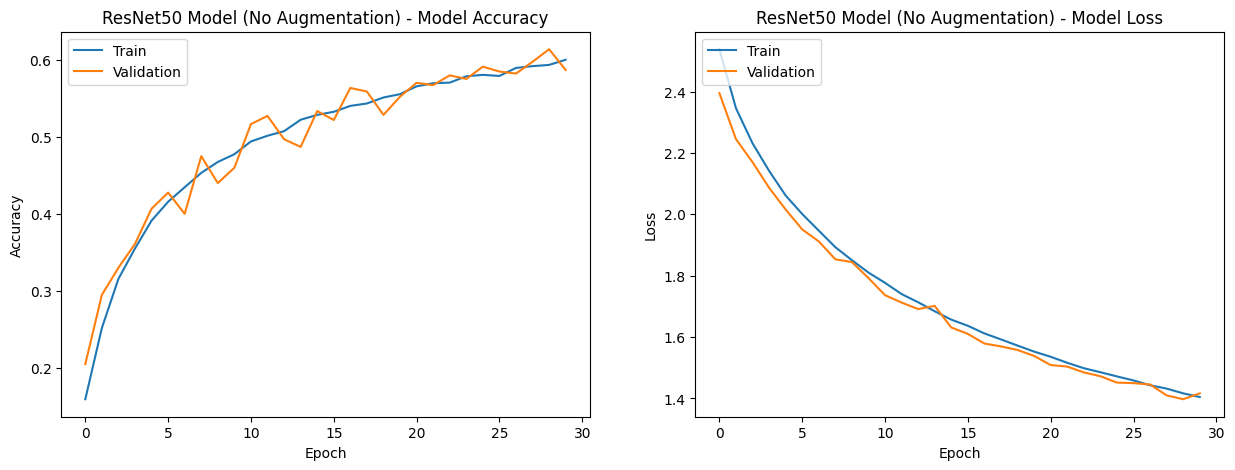

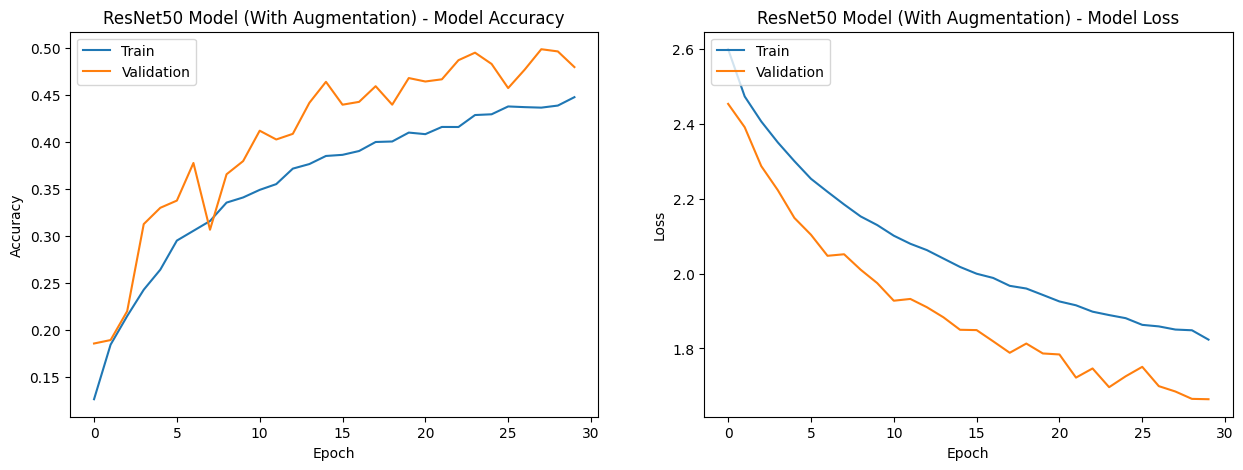

In [22]:
plot_training_history(history_resnet50, 'ResNet50 Model (No Augmentation)')
plot_training_history(history_resnet50_augmented, 'ResNet50 Model (With Augmentation)')

#Evaluation of models on test set

In [23]:
cnn_test_loss, cnn_test_accuracy = cnn_model.evaluate(test_generator)
cnn_augmented_test_loss, cnn_augmented_test_accuracy = cnn_model_augmented.evaluate(test_generator)

resnet50_test_loss, resnet50_test_accuracy = resnet50_model.evaluate(test_generator)
resnet50_augmented_test_loss, resnet50_augmented_test_accuracy = resnet50_model_augmented.evaluate(test_generator)

print(f"Test Accuracy (CNN, No Augmentation): {cnn_test_accuracy}")
print(f"Test Accuracy (CNN, With Augmentation): {cnn_augmented_test_accuracy}")

print(f"Test Accuracy (ResNet50, No Augmentation): {resnet50_test_accuracy}")
print(f"Test Accuracy (ResNet50, With Augmentation): {resnet50_augmented_test_accuracy}")


94/94 [==============================] - 8s 85ms/step - loss: 1.6667 - accuracy: 0.4773
Test Accuracy (CNN, No Augmentation): 0.9290000200271606
Test Accuracy (CNN, With Augmentation): 0.9683333039283752
Test Accuracy (ResNet50, No Augmentation): 0.5709999799728394
Test Accuracy (ResNet50, With Augmentation): 0.47733333706855774


CNN model showed the good perfomance both on train and test data. The model had accuracy of 0.9290, which improved significantly after augmentation to 0.9683. ResNet50 didnt not perform well for this task. To conclude, CNN is best choice for vegetable prediction task. If model is trained sufficiently, the accuracy can improve significantly.
